In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
from spheres_JJ import ellipsoid_gen_axis_change

from rotation import rotate_point_cloud
   
nclouds = 20000
npoints = 100

# Labels are uniform(ish) in (1,6)
labels = ((torch.rand(nclouds) * 5) + 1).view(-1,1)
labels_train = labels


# The point clouds

ellipsoids = torch.from_numpy(ellipsoid_gen_axis_change(0.0,1 , 1 ,labels, nclouds, npoints))
trainset = ellipsoids

dataset = TensorDataset(trainset, labels)

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

#####################################################
# Testing

ncloudstest = 10000
npointstest = 100

# Labels are uniform(ish) in (1,6)
testlabels = ((torch.rand(ncloudstest) * 5) + 1).view(-1,1)

# The point clouds
testset = torch.from_numpy(ellipsoid_gen_axis_change(0.0,1 , 1 ,testlabels, ncloudstest, npointstest))
test = testset
testset_keep = testset


labels_test = testlabels

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

#############################################################3



In [2]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = F.relu(self.bn6(x))
        #x = self.bn6(x)
        return x

In [3]:
net = PointNetCls(k=1)

nepochs = 30

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)

for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    epoch_train_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(rotate_point_cloud(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        counter += 1
    
    #net.eval()
    train_loss[epoch] = criterion(net(trainset), labels_train)
    test_loss[epoch] = criterion(net(testset_keep), labels_test)
    #net.train()
    epoch_train_loss = 0.0
print('Finished Training')

[1,   100] loss: 5.478
[1,   200] loss: 4.941
[1,   300] loss: 4.648
[1,   400] loss: 4.181
[1,   500] loss: 4.051
[1,   600] loss: 3.570
[2,   100] loss: 3.564
[2,   200] loss: 3.342
[2,   300] loss: 3.133
[2,   400] loss: 3.203
[2,   500] loss: 2.879
[2,   600] loss: 2.784
[3,   100] loss: 2.782
[3,   200] loss: 2.750
[3,   300] loss: 2.834
[3,   400] loss: 2.752
[3,   500] loss: 2.762
[3,   600] loss: 2.828
[4,   100] loss: 2.577
[4,   200] loss: 2.658
[4,   300] loss: 2.532
[4,   400] loss: 2.596
[4,   500] loss: 2.781
[4,   600] loss: 2.733
[5,   100] loss: 2.523
[5,   200] loss: 2.675
[5,   300] loss: 2.582
[5,   400] loss: 2.875
[5,   500] loss: 2.695
[5,   600] loss: 2.661
[6,   100] loss: 2.478
[6,   200] loss: 2.556
[6,   300] loss: 2.449
[6,   400] loss: 2.692
[6,   500] loss: 2.655
[6,   600] loss: 2.563
[7,   100] loss: 2.794
[7,   200] loss: 2.828
[7,   300] loss: 2.563
[7,   400] loss: 2.785
[7,   500] loss: 2.692
[7,   600] loss: 2.601
[8,   100] loss: 2.637
[8,   200] 

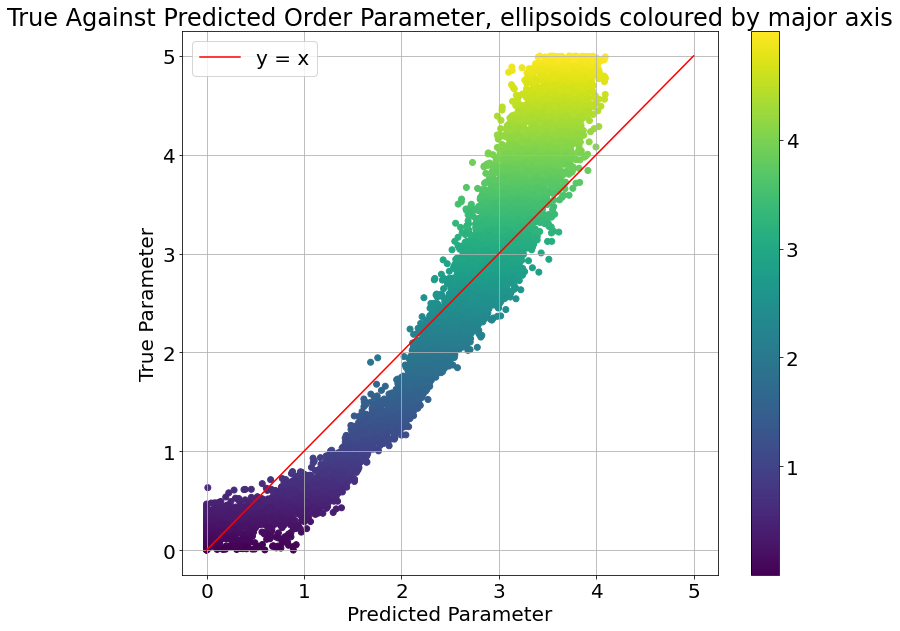

In [6]:
outputs = net(test)
x = outputs.detach().numpy()
y = labels_test

# plot the data
font = {'size'   : 20}
plt.figure(figsize=(12,10))
plt.scatter(x,y, c = labels_test)
plt.plot(np.linspace(0, 5, 10), np.power(np.linspace(0, 5, 10), 1), color = 'r', label = 'y = x')
plt.colorbar()
plt.grid()
plt.title("True Against Predicted Order Parameter, ellipsoids coloured by major axis")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.legend()
plt.rc('font', **font)
plt.savefig('Truevpredaxis_nomult.jpeg', bbox_inches ='tight')
plt.show()

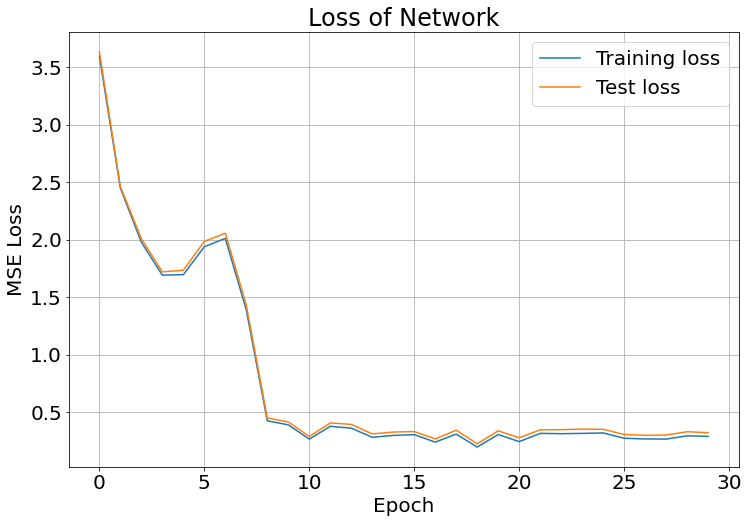

In [5]:
x = np.arange(nepochs)
plt.figure(figsize=(12,8))
plt.rc('font', **font)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, test_loss, label='Test loss')
plt.legend()
plt.grid()
plt.title('Loss of Network')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.savefig('Loss3D_major_pred.jpeg', bbox_inches ='tight')
plt.show()